In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm
from sklearn.metrics import r2_score

# Ignore Warnings
import warnings
warnings.filterwarnings(action='ignore')

In [16]:
#Reading the data to dataframe
df = pd.read_csv('day.csv')

In [17]:
print(df.shape)
df.head(1)

(730, 16)


,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,01-01-2018,1,0,1,0,6,0,2,14.110847,18.18125,80.5833,10.749882,331,654,985


In [18]:
#Droping the duplicates
df = df.drop_duplicates()
df.shape

(730, 16)

Getting basic information about data

In [19]:
df.info()
#The data doesnot contains any null values since the non-null count is same as number of rows

<class 'pandas.core.frame.DataFrame'>
Int64Index: 730 entries, 0 to 729
Data columns (total 16 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   instant     730 non-null    int64  
 1   dteday      730 non-null    object 
 2   season      730 non-null    int64  
 3   yr          730 non-null    int64  
 4   mnth        730 non-null    int64  
 5   holiday     730 non-null    int64  
 6   weekday     730 non-null    int64  
 7   workingday  730 non-null    int64  
 8   weathersit  730 non-null    int64  
 9   temp        730 non-null    float64
 10  atemp       730 non-null    float64
 11  hum         730 non-null    float64
 12  windspeed   730 non-null    float64
 13  casual      730 non-null    int64  
 14  registered  730 non-null    int64  
 15  cnt         730 non-null    int64  
dtypes: float64(4), int64(11), object(1)
memory usage: 97.0+ KB


In [20]:
df.describe()

,instant,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
count,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000
mean,365.500000,2.498630,0.500000,6.526027,0.028767,2.997260,0.683562,1.394521,20.319259,23.726322,62.765175,12.763620,849.249315,3658.757534,4508.006849
std,210.877136,1.110184,0.500343,3.450215,0.167266,2.006161,0.465405,0.544807,7.506729,8.150308,14.237589,5.195841,686.479875,1559.758728,1936.011647
min,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,2.424346,3.953480,0.000000,1.500244,2.000000,20.000000,22.000000
25%,183.250000,2.000000,0.000000,4.000000,0.000000,1.000000,0.000000,1.000000,13.811885,16.889713,52.000000,9.041650,316.250000,2502.250000,3169.750000
50%,365.500000,3.000000,0.500000,7.000000,0.000000,3.000000,1.000000,1.000000,20.465826,24.368225,62.625000,12.125325,717.000000,3664.500000,4548.500000
75%,547.750000,3.000000,1.000000,10.000000,0.000000,5.000000,1.000000,2.000000,26.880615,30.445775,72.989575,15.625589,1096.500000,4783.250000,5966.000000
max,730.000000,4.000000,1.000000,12.000000,1.000000,6.000000,1.000000,3.000000,35.328347,42.044800,97.250000,34.000021,3410.000000,6946.000000,8714.000000


In [21]:
# Removing the non relevant columns
not_relevant_columns = [
    "dteday",
    "instant"
]
df = df.drop(columns=not_relevant_columns)
print(df.shape)
df.head(1)

(730, 14)


,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,0,1,0,6,0,2,14.110847,18.18125,80.5833,10.749882,331,654,985


In [22]:
# Replacing the columns with meaningful categorical columns
ref = {
    'season': {1:'spring',2:'summer',3:'fall',4:'winter'},
    'yr': {0:'2018',1:'2019'},
    'mnth': {1:'Jan',2:'Feb',3:'Mar',4:'Apr',5:'May',6:'June',7:'July',8:'Aug',9:'Sept',10:'Oct',11:'Nov',12:'Dec'},
    'holiday': {0:'No Holiday',1:'Holiday'},
    'weekday': {0:'Mon',1:'Tue',2:'Wed',3:'Thurs',4:'Fri',5:'Sat',6:'Sun'},
    'workingday': {0:'Working Day',1:'Non Working Day'},
    'weathersit': {1:'Clear',2:'Mist and/or Cloudy',3:'Light Rain',4:'Heavy Rain'}
}
for k,v in ref.items():
  df[k] = df[k].replace(v)

df.head(1)

,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,spring,2018,Jan,No Holiday,Sun,Working Day,Mist and/or Cloudy,14.110847,18.18125,80.5833,10.749882,331,654,985


## EDA

In [23]:
num_col = ['temp', 'atemp', 'hum', 'windspeed', 'casual', 'registered']
cat_col = ['season', 'yr', 'mnth', 'holiday', 'weekday', 'workingday', 'weathersit']

### Univariate Analysis

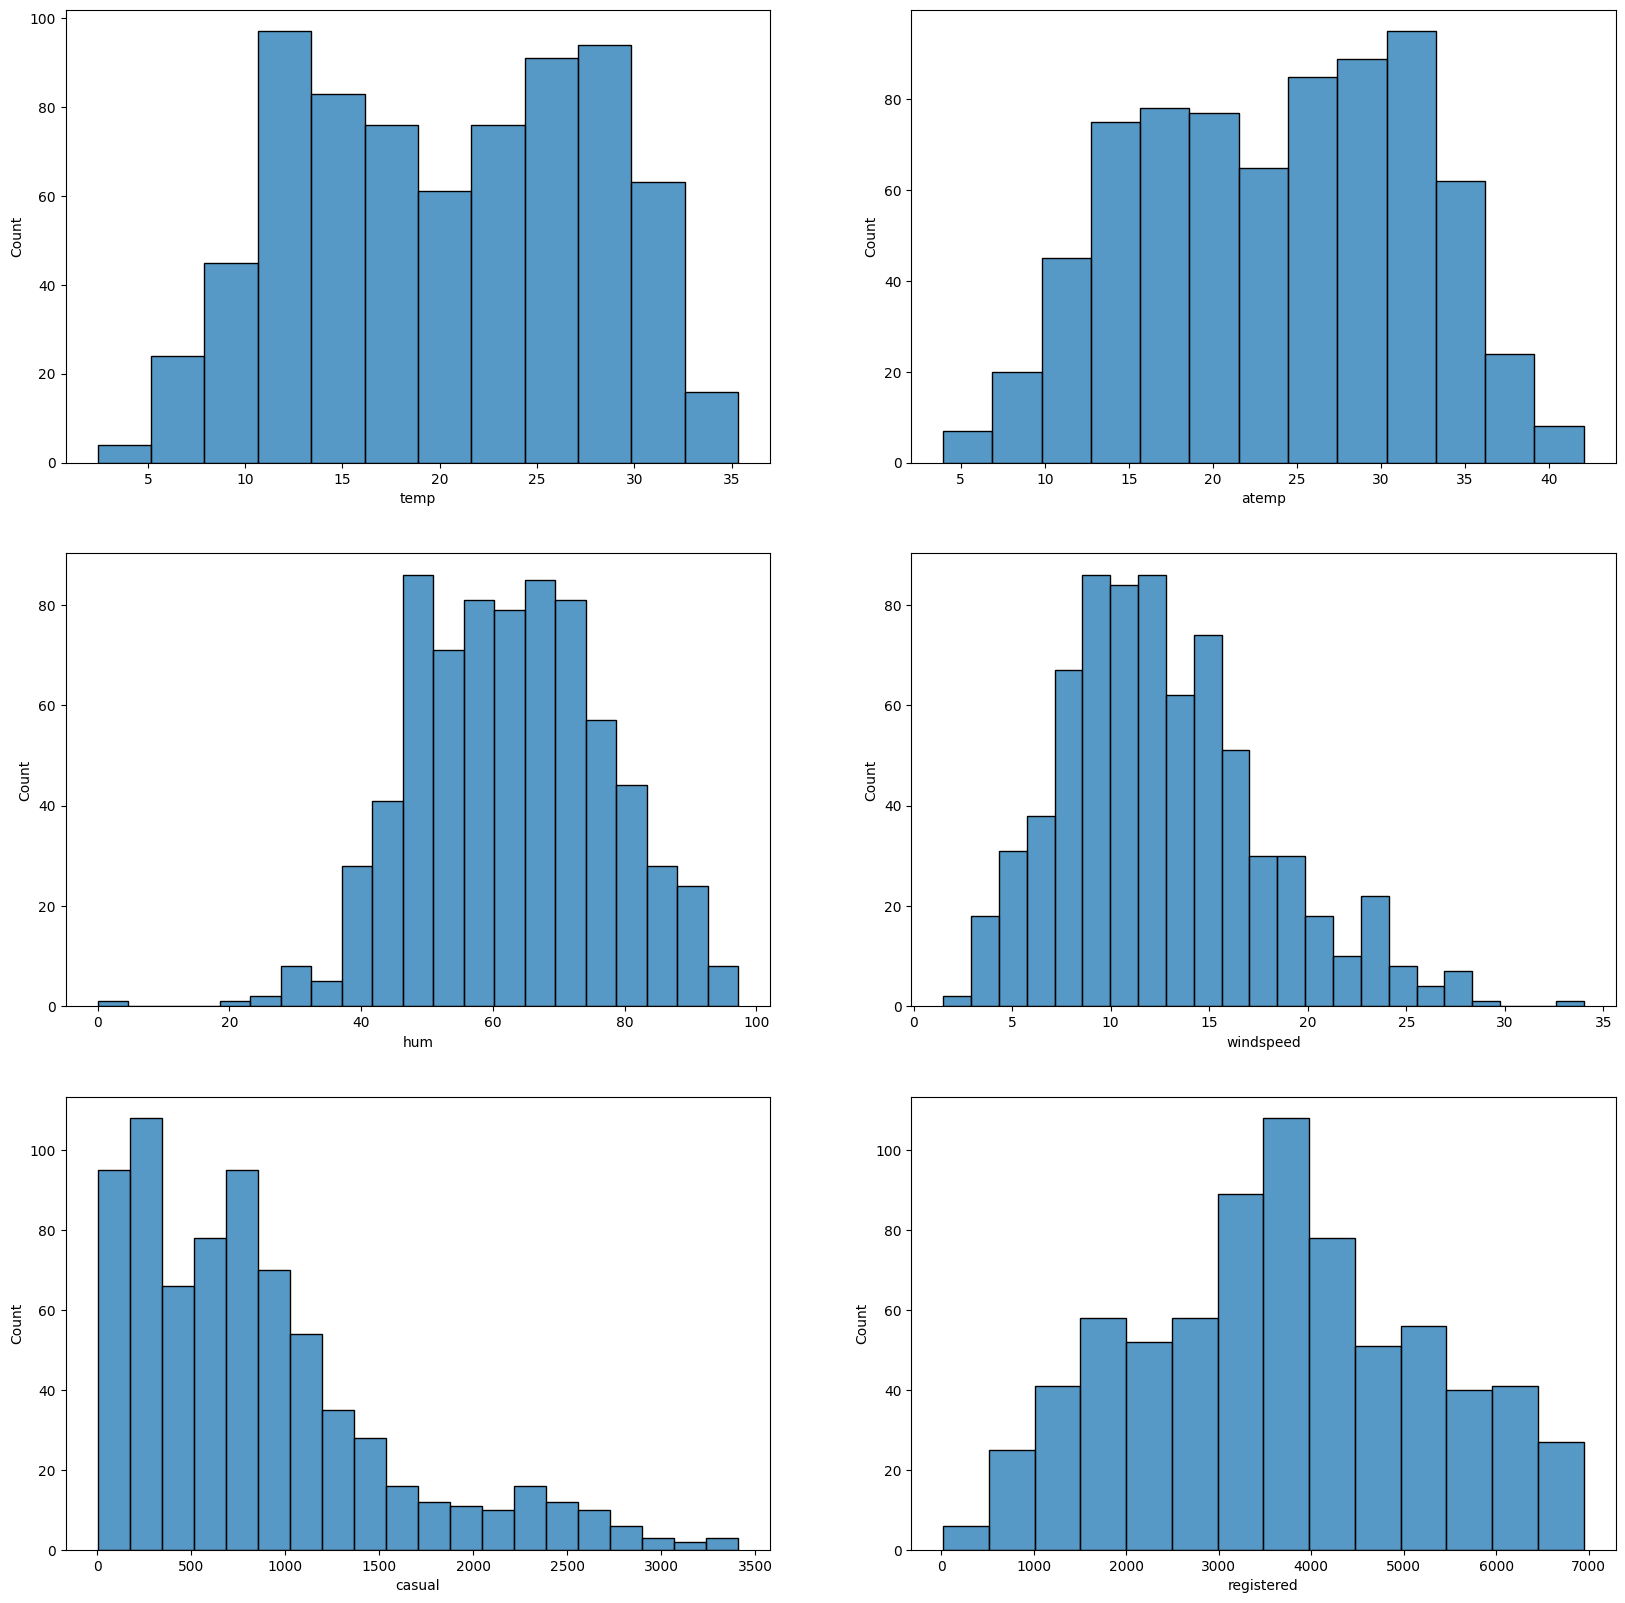

In [24]:
plt.figure(figsize=(20,20))
for i, v in enumerate(num_col):
  plt.subplot(3,2,i+1)
  sns.histplot(x=df[v])
plt.show()

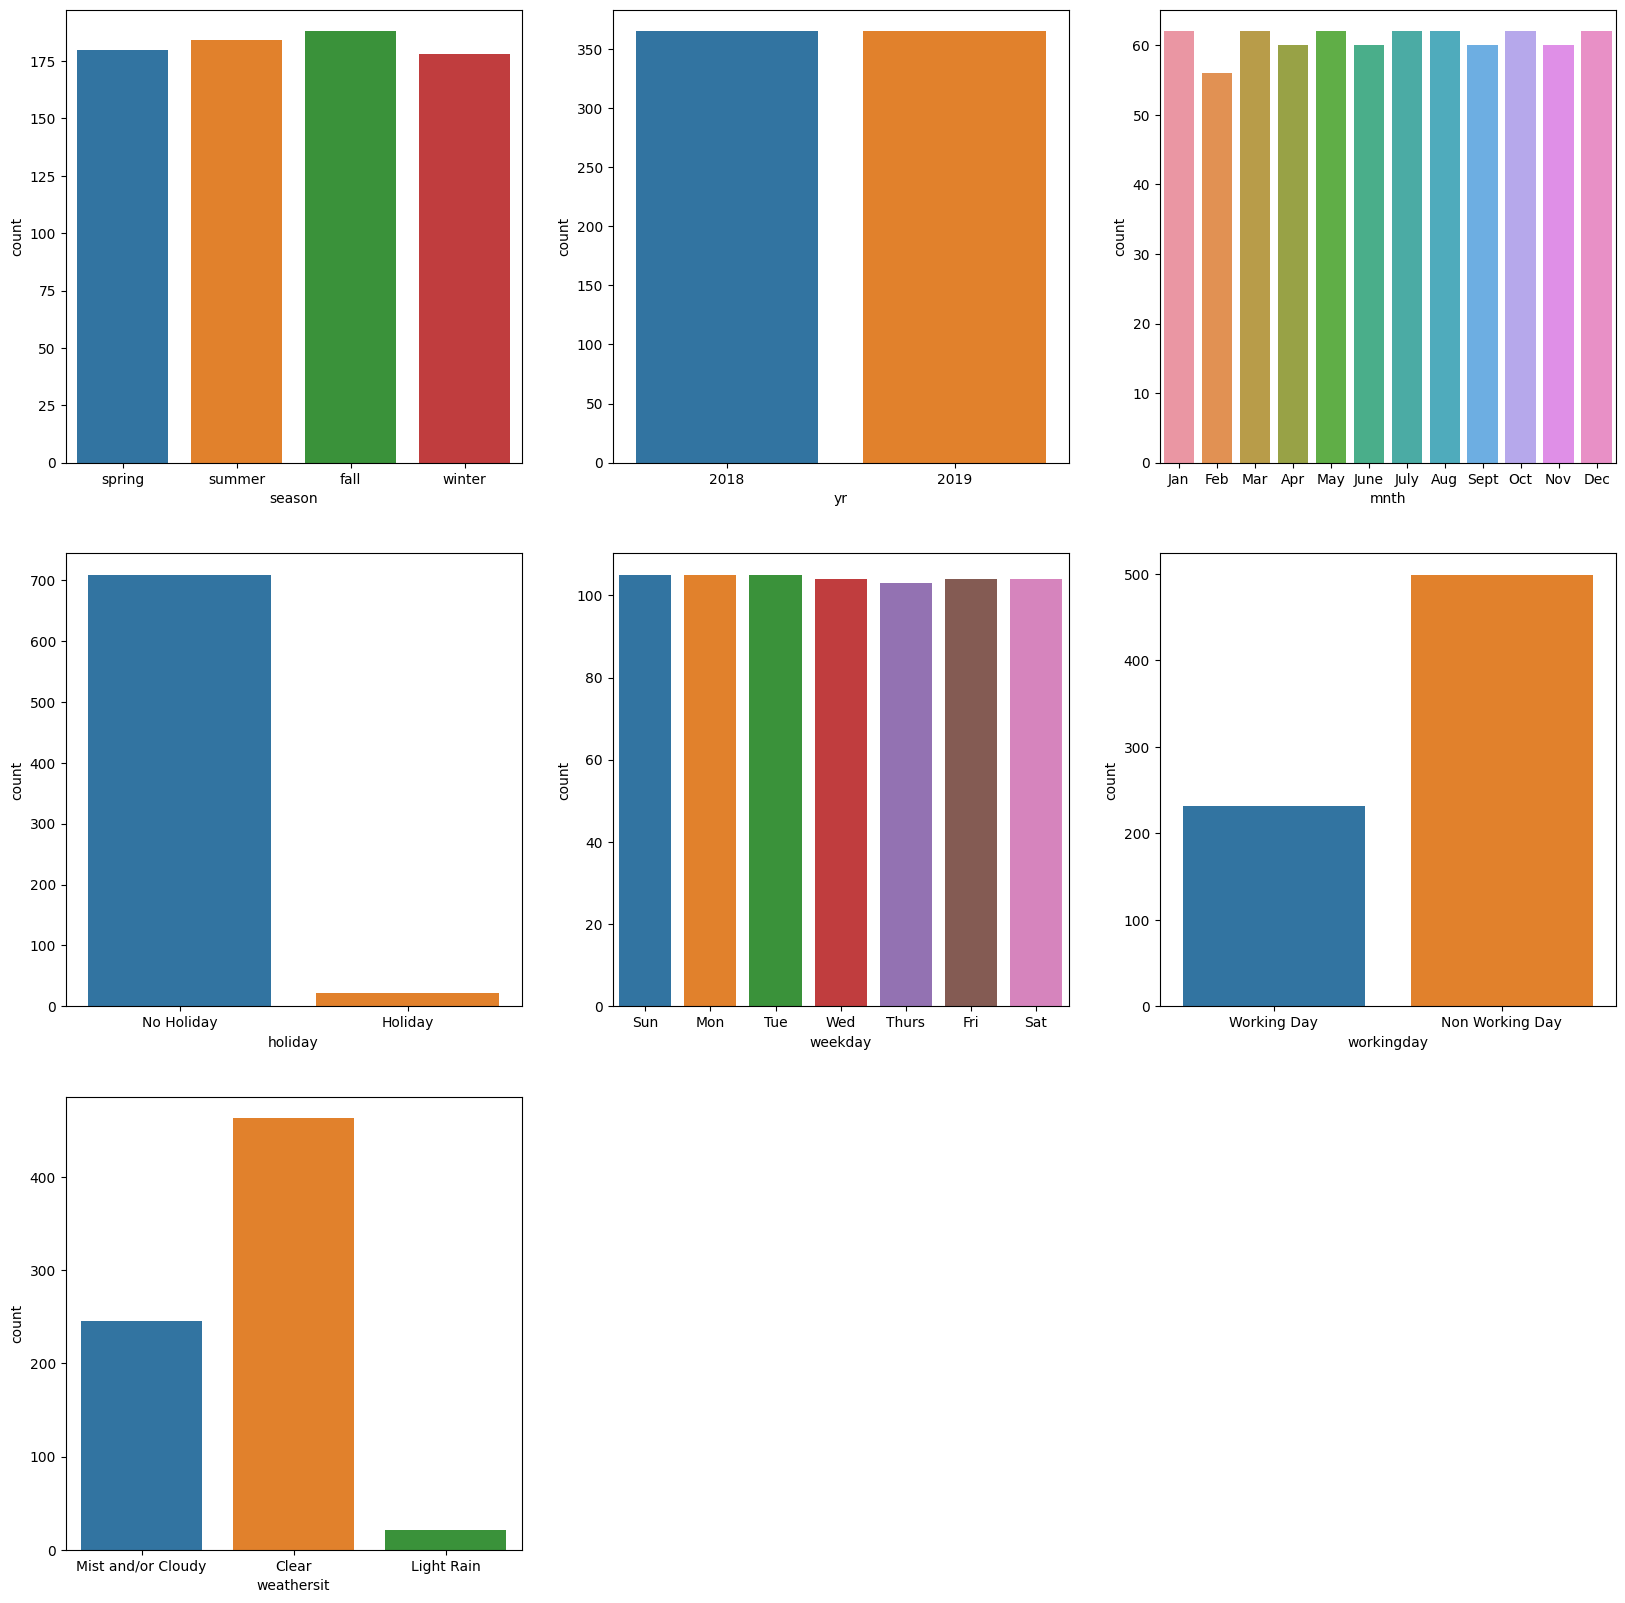

In [25]:
plt.figure(figsize=(20,20))
for i, v in enumerate(cat_col):
  plt.subplot(3,3,i+1)
  sns.countplot(x=df[v])
plt.show()

### Bivariate Analysis

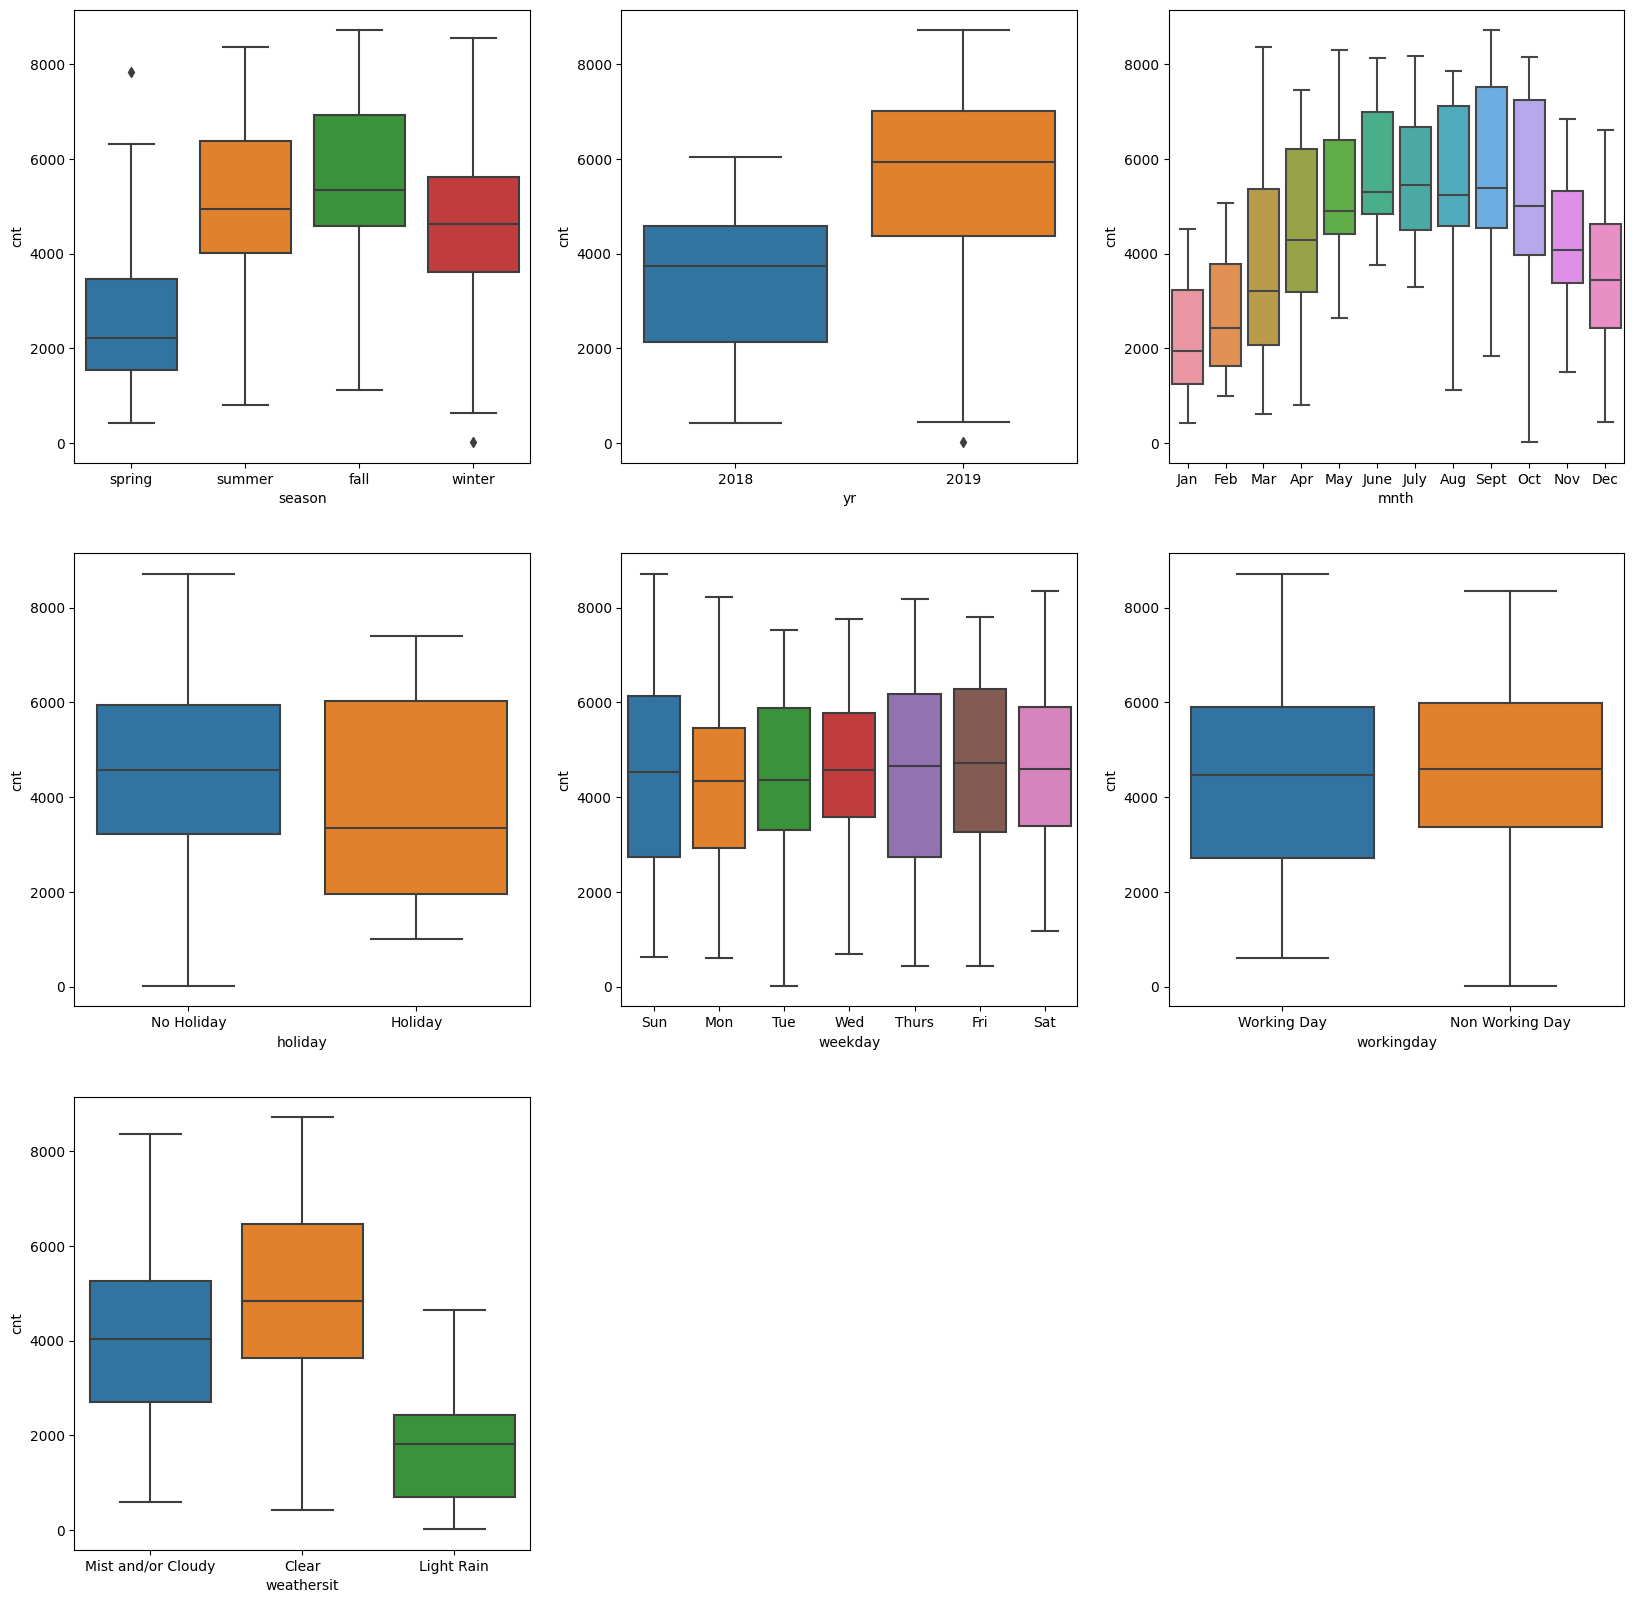

In [26]:
plt.figure(figsize=(20,20))
for i, v in enumerate(cat_col):
  plt.subplot(3,3,i+1)
  sns.boxplot(x = v, y = 'cnt', data = df)
plt.show()

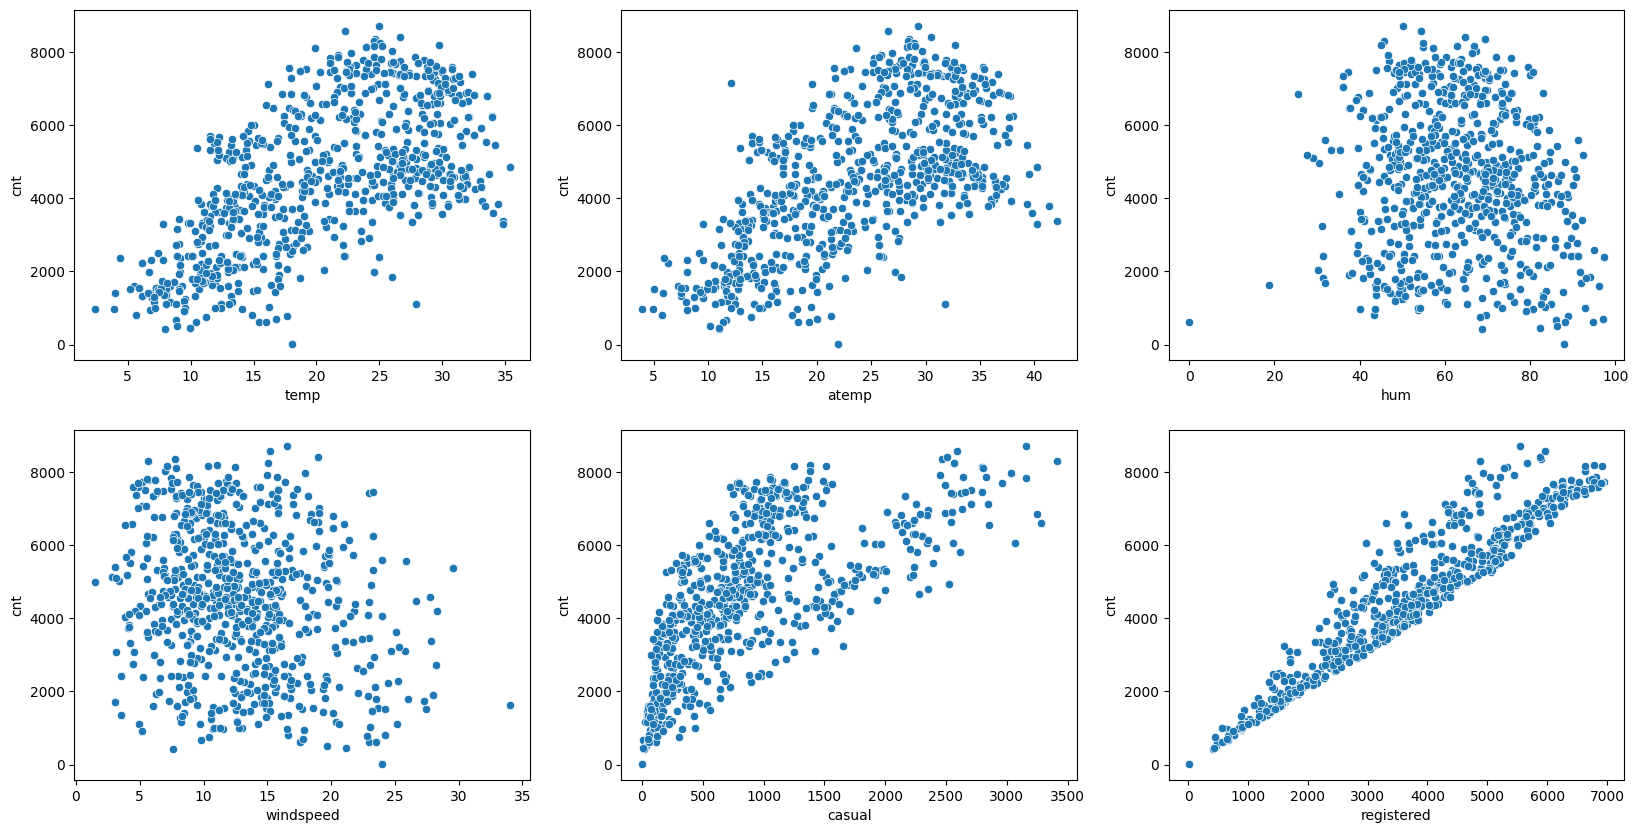

In [27]:
plt.figure(figsize=(20,10))
for i, v in enumerate(num_col):
  plt.subplot(2,3,i+1)
  sns.scatterplot(x = v, y = 'cnt', data = df)
plt.show()

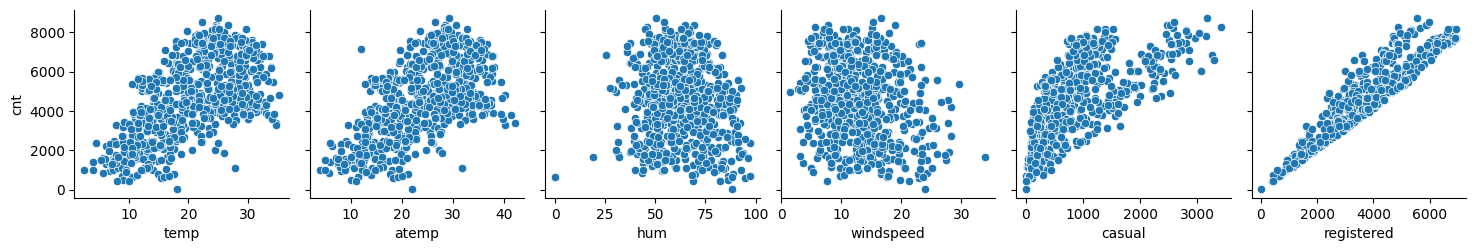

In [28]:
sns.pairplot(data=df, x_vars=num_col, y_vars='cnt')
plt.show()

# Pre Processing Step

## Dummy variable creation

In [29]:
cat_col = ['season', 'yr', 'mnth', 'holiday', 'weekday', 'workingday', 'weathersit']

dummy = pd.get_dummies(df[cat_col], drop_first=True)
final = pd.concat([df, dummy], axis=1)
final = final.drop(cat_col, axis=1)

In [30]:
final.head()

,temp,atemp,hum,windspeed,casual,registered,cnt,season_spring,season_summer,season_winter,...,holiday_No Holiday,weekday_Mon,weekday_Sat,weekday_Sun,weekday_Thurs,weekday_Tue,weekday_Wed,workingday_Working Day,weathersit_Light Rain,weathersit_Mist and/or Cloudy
0,14.110847,18.18125,80.5833,10.749882,331,654,985,1,0,0,...,1,0,0,1,0,0,0,1,0,1
1,14.902598,17.68695,69.6087,16.652113,131,670,801,1,0,0,...,1,1,0,0,0,0,0,1,0,1
2,8.050924,9.47025,43.7273,16.636703,120,1229,1349,1,0,0,...,1,0,0,0,0,1,0,0,0,0
3,8.200000,10.60610,59.0435,10.739832,108,1454,1562,1,0,0,...,1,0,0,0,0,0,1,0,0,0
4,9.305237,11.46350,43.6957,12.522300,82,1518,1600,1,0,0,...,1,0,0,0,1,0,0,0,0,0


In [31]:
df_train, df_test = train_test_split(final, train_size=0.7,random_state=100)
print(df_train.shape)
print(df_test.shape)

(510, 32)
(220, 32)


In [32]:
scaler=MinMaxScaler()

In [33]:
scale = ['temp', 'atemp', 'hum', 'windspeed', 'casual', 'registered', 'cnt']

In [34]:
df_train[scale]=scaler.fit_transform(df_train[scale])
df_train.head()

,temp,atemp,hum,windspeed,casual,registered,cnt,season_spring,season_summer,season_winter,...,holiday_No Holiday,weekday_Mon,weekday_Sat,weekday_Sun,weekday_Thurs,weekday_Tue,weekday_Wed,workingday_Working Day,weathersit_Light Rain,weathersit_Mist and/or Cloudy
576,0.815169,0.766351,0.725633,0.264686,0.294422,0.899220,0.827658,0,0,0,...,1,0,0,0,0,0,1,0,0,0
426,0.442393,0.438975,0.640189,0.255342,0.290765,0.446145,0.465255,1,0,0,...,1,0,0,1,0,0,0,1,0,1
728,0.245101,0.200348,0.498067,0.663106,0.110332,0.203869,0.204096,1,0,0,...,1,1,0,0,0,0,0,1,0,0
482,0.395666,0.391735,0.504508,0.188475,0.340750,0.444701,0.482973,0,1,0,...,1,0,0,1,0,0,0,1,0,1
111,0.345824,0.318819,0.751824,0.380981,0.053337,0.214554,0.191095,0,1,0,...,1,0,1,0,0,0,0,0,0,1


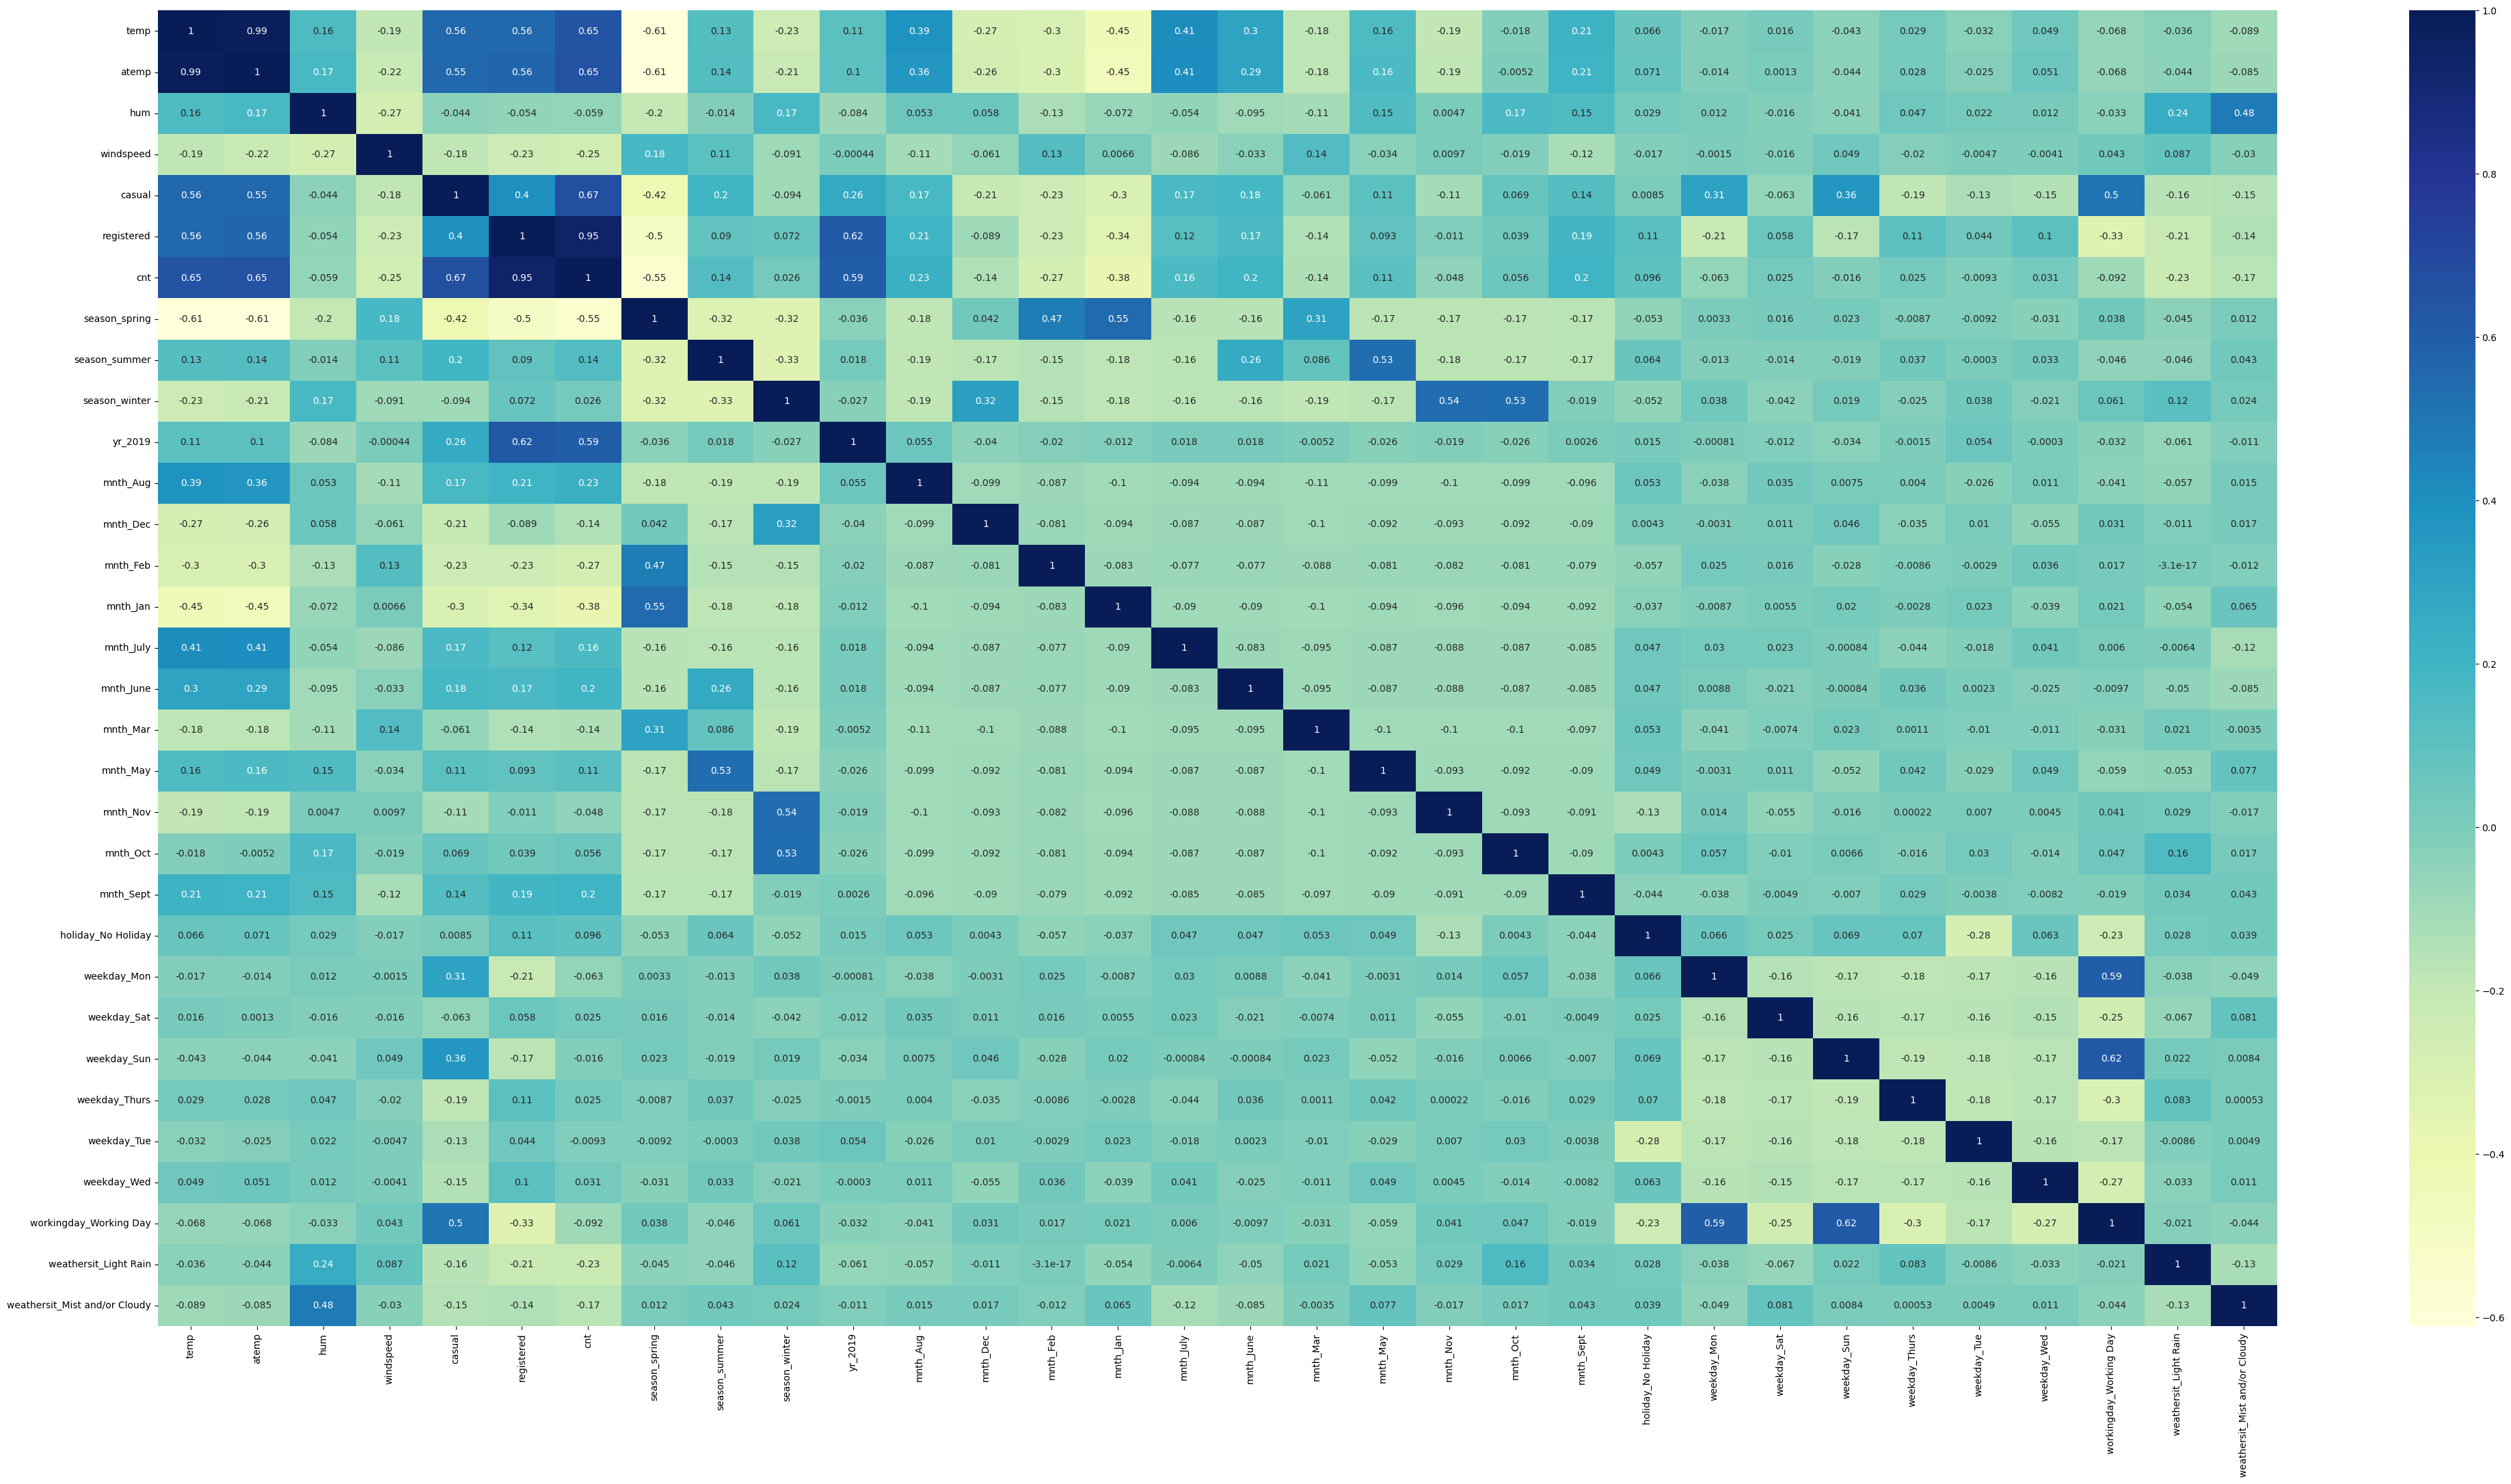

In [35]:
# Corelation with dummy variables
plt.figure(figsize=(50,25))
sns.heatmap(df_train.corr(),annot=True,cmap='YlGnBu')
plt.show()

In [36]:
# Split df_train further into X_train and y_train
y_train=df_train.pop('cnt')
X_train=df_train

In [37]:
# lm = LinearRegression()
# lm.fit(X_train, y_train)

# rfe = RFE(estimator=lm, n_features_to_select=20)
# rfe = rfe.fit(X_train, y_train)

In [38]:
# selected_features = X_train.columns[rfe.support_]

In [39]:
# X_train=X_train[selected_features]

In [40]:
X_train_lm_1 = sm.add_constant(X_train)
lr_1 = sm.OLS(y_train,X_train_lm_1).fit()
print(lr_1.summary())

vif_data=pd.DataFrame()
vif_data["Feature"]=X_train.columns

vif_data["VIF"]=[variance_inflation_factor(X_train.values,i) \
                 for i in range(len(X_train.columns))]
vif_data.sort_values(by = "VIF", ascending = False)
vif_data

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 2.718e+30
Date:                Tue, 12 Dec 2023   Prob (F-statistic):               0.00
Time:                        12:03:24   Log-Likelihood:                 17202.
No. Observations:                 510   AIC:                        -3.434e+04
Df Residuals:                     479   BIC:                        -3.421e+04
Df Model:                          30                                         
Covariance Type:            nonrobust                                         
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
const         

,Feature,VIF
0,temp,68.413211
1,atemp,56.187977
2,hum,2.120496
3,windspeed,1.439771
4,casual,4.484803
5,registered,7.741709
6,season_spring,10.842505
7,season_summer,8.395149
8,season_winter,9.949045
9,yr_2019,3.260853


In [41]:
X_train_new = X_train.drop(['atemp'], axis = 1)

In [42]:
X_train_lm_2 = sm.add_constant(X_train_new)
lr_2 = sm.OLS(y_train,X_train_lm_2).fit()
print(lr_2.summary())
vif_data=pd.DataFrame()
vif_data["Feature"]=X_train_new.columns

vif_data["VIF"]=[variance_inflation_factor(X_train_new.values,i) \
                 for i in range(len(X_train_new.columns))]
vif_data.sort_values(by = "VIF", ascending = False)
vif_data

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 6.820e+29
Date:                Tue, 12 Dec 2023   Prob (F-statistic):               0.00
Time:                        12:03:24   Log-Likelihood:                 16840.
No. Observations:                 510   AIC:                        -3.362e+04
Df Residuals:                     480   BIC:                        -3.349e+04
Df Model:                          29                                         
Covariance Type:            nonrobust                                         
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
const         

,Feature,VIF
0,temp,8.542361
1,hum,2.117874
2,windspeed,1.381529
3,casual,4.478745
4,registered,7.724458
5,season_spring,10.821290
6,season_summer,8.366034
7,season_winter,9.937141
8,yr_2019,3.253279
9,mnth_Aug,6.379201


In [43]:
X_train_new = X_train_new.drop(['holiday_No Holiday'], axis = 1)

In [44]:
X_train_lm_3 = sm.add_constant(X_train_new)
lr_3 = sm.OLS(y_train,X_train_lm_3).fit()
print(lr_3.summary())
vif_data=pd.DataFrame()
vif_data["Feature"]=X_train_new.columns

vif_data["VIF"]=[variance_inflation_factor(X_train_new.values,i) \
                 for i in range(len(X_train_new.columns))]
vif_data.sort_values(by = "VIF", ascending = False)
vif_data

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 9.624e+29
Date:                Tue, 12 Dec 2023   Prob (F-statistic):               0.00
Time:                        12:03:25   Log-Likelihood:                 16928.
No. Observations:                 510   AIC:                        -3.380e+04
Df Residuals:                     480   BIC:                        -3.367e+04
Df Model:                          29                                         
Covariance Type:            nonrobust                                         
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
const         

,Feature,VIF
0,temp,51.948091
1,hum,38.700229
2,windspeed,5.499935
3,casual,11.288745
4,registered,41.546638
5,season_spring,11.949118
6,season_summer,7.721891
7,season_winter,12.929080
8,yr_2019,6.101151
9,mnth_Aug,6.140347


In [45]:
X_train_new = X_train_new.drop(['workingday_Working Day'], axis = 1)

In [46]:
X_train_lm_4 = sm.add_constant(X_train_new)
lr_4 = sm.OLS(y_train,X_train_lm_4).fit()
print(lr_4.summary())
vif_data=pd.DataFrame()
vif_data["Feature"]=X_train_new.columns

vif_data["VIF"]=[variance_inflation_factor(X_train_new.values,i) \
                 for i in range(len(X_train_new.columns))]
vif_data.sort_values(by = "VIF", ascending = False)
vif_data

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 3.256e+29
Date:                Tue, 12 Dec 2023   Prob (F-statistic):               0.00
Time:                        12:03:25   Log-Likelihood:                 16642.
No. Observations:                 510   AIC:                        -3.323e+04
Df Residuals:                     481   BIC:                        -3.310e+04
Df Model:                          28                                         
Covariance Type:            nonrobust                                         
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
const         

,Feature,VIF
0,temp,51.276181
1,hum,38.700229
2,windspeed,5.497815
3,casual,10.710531
4,registered,37.772697
5,season_spring,11.928826
6,season_summer,7.685029
7,season_winter,12.912586
8,yr_2019,5.916178
9,mnth_Aug,6.134020


In [47]:
X_train_new = X_train_new.drop(['registered'], axis = 1)

In [48]:
X_train_lm_5 = sm.add_constant(X_train_new)
lr_5 = sm.OLS(y_train,X_train_lm_5).fit()
print(lr_5.summary())
vif_data=pd.DataFrame()
vif_data["Feature"]=X_train_new.columns

vif_data["VIF"]=[variance_inflation_factor(X_train_new.values,i) \
                 for i in range(len(X_train_new.columns))]
vif_data.sort_values(by = "VIF", ascending = False)
vif_data

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.906
Model:                            OLS   Adj. R-squared:                  0.901
Method:                 Least Squares   F-statistic:                     172.0
Date:                Tue, 12 Dec 2023   Prob (F-statistic):          4.93e-228
Time:                        12:03:25   Log-Likelihood:                 641.81
No. Observations:                 510   AIC:                            -1228.
Df Residuals:                     482   BIC:                            -1109.
Df Model:                          27                                         
Covariance Type:            nonrobust                                         
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
const         

,Feature,VIF
0,temp,43.903919
1,hum,38.692279
2,windspeed,5.471789
3,casual,10.244840
4,season_spring,11.858310
5,season_summer,7.122718
6,season_winter,11.693823
7,yr_2019,2.474297
8,mnth_Aug,5.830650
9,mnth_Dec,4.877926


In [49]:
X_train_new = X_train_new.drop(['hum'], axis = 1)

In [50]:
X_train_lm_6 = sm.add_constant(X_train_new)
lr_6 = sm.OLS(y_train,X_train_lm_6).fit()
print(lr_6.summary())
vif_data=pd.DataFrame()
vif_data["Feature"]=X_train_new.columns

vif_data["VIF"]=[variance_inflation_factor(X_train_new.values,i) \
                 for i in range(len(X_train_new.columns))]
vif_data.sort_values(by = "VIF", ascending = False)
vif_data

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.905
Model:                            OLS   Adj. R-squared:                  0.899
Method:                 Least Squares   F-statistic:                     176.2
Date:                Tue, 12 Dec 2023   Prob (F-statistic):          1.15e-227
Time:                        12:03:25   Log-Likelihood:                 638.14
No. Observations:                 510   AIC:                            -1222.
Df Residuals:                     483   BIC:                            -1108.
Df Model:                          26                                         
Covariance Type:            nonrobust                                         
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
const         

,Feature,VIF
0,temp,31.905948
1,windspeed,5.238924
2,casual,10.090725
3,season_spring,11.379886
4,season_summer,5.987941
5,season_winter,11.485819
6,yr_2019,2.467544
7,mnth_Aug,5.627640
8,mnth_Dec,4.193476
9,mnth_Feb,3.695004


In [51]:
X_train_new = X_train_new.drop(['season_spring'], axis = 1)

In [52]:
X_train_lm_7 = sm.add_constant(X_train_new)
lr_7 = sm.OLS(y_train,X_train_lm_7).fit()
print(lr_7.summary())
vif_data=pd.DataFrame()
vif_data["Feature"]=X_train_new.columns

vif_data["VIF"]=[variance_inflation_factor(X_train_new.values,i) \
                 for i in range(len(X_train_new.columns))]
vif_data.sort_values(by = "VIF", ascending = False)
vif_data

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.904
Model:                            OLS   Adj. R-squared:                  0.899
Method:                 Least Squares   F-statistic:                     182.0
Date:                Tue, 12 Dec 2023   Prob (F-statistic):          5.91e-228
Time:                        12:03:25   Log-Likelihood:                 636.08
No. Observations:                 510   AIC:                            -1220.
Df Residuals:                     484   BIC:                            -1110.
Df Model:                          25                                         
Covariance Type:            nonrobust                                         
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
const         

,Feature,VIF
0,temp,30.510769
1,windspeed,5.022652
2,casual,10.088797
3,season_summer,4.317232
4,season_winter,7.962613
5,yr_2019,2.463779
6,mnth_Aug,5.074538
7,mnth_Dec,3.322511
8,mnth_Feb,1.846809
9,mnth_Jan,1.889675


In [53]:
X_train_new = X_train_new.drop(['casual'], axis = 1)

In [54]:
X_train_lm_8 = sm.add_constant(X_train_new)
lr_8 = sm.OLS(y_train,X_train_lm_8).fit()
print(lr_8.summary())
vif_data=pd.DataFrame()
vif_data["Feature"]=X_train_new.columns

vif_data["VIF"]=[variance_inflation_factor(X_train_new.values,i) \
                 for i in range(len(X_train_new.columns))]
vif_data.sort_values(by = "VIF", ascending = False)
vif_data

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.844
Model:                            OLS   Adj. R-squared:                  0.836
Method:                 Least Squares   F-statistic:                     109.2
Date:                Tue, 12 Dec 2023   Prob (F-statistic):          2.43e-178
Time:                        12:03:26   Log-Likelihood:                 512.39
No. Observations:                 510   AIC:                            -974.8
Df Residuals:                     485   BIC:                            -868.9
Df Model:                          24                                         
Covariance Type:            nonrobust                                         
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
const         

,Feature,VIF
0,temp,25.180018
1,windspeed,4.705787
2,season_summer,4.204506
3,season_winter,7.962291
4,yr_2019,2.110963
5,mnth_Aug,5.069725
6,mnth_Dec,3.271881
7,mnth_Feb,1.815626
8,mnth_Jan,1.837442
9,mnth_July,4.684511


In [55]:
X_train_new = X_train_new.drop(['mnth_July'], axis = 1)

In [56]:
X_train_lm_9 = sm.add_constant(X_train_new)
lr_9 = sm.OLS(y_train,X_train_lm_9).fit()
print(lr_9.summary())
vif_data=pd.DataFrame()
vif_data["Feature"]=X_train_new.columns

vif_data["VIF"]=[variance_inflation_factor(X_train_new.values,i) \
                 for i in range(len(X_train_new.columns))]
vif_data.sort_values(by = "VIF", ascending = False)
vif_data

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.844
Model:                            OLS   Adj. R-squared:                  0.836
Method:                 Least Squares   F-statistic:                     114.2
Date:                Tue, 12 Dec 2023   Prob (F-statistic):          2.25e-179
Time:                        12:03:26   Log-Likelihood:                 512.39
No. Observations:                 510   AIC:                            -976.8
Df Residuals:                     486   BIC:                            -875.2
Df Model:                          23                                         
Covariance Type:            nonrobust                                         
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
const         

,Feature,VIF
0,temp,8.703882
1,windspeed,4.700970
2,season_summer,2.905765
3,season_winter,7.962291
4,yr_2019,2.098804
5,mnth_Aug,1.894320
6,mnth_Dec,2.745043
7,mnth_Feb,1.506741
8,mnth_Jan,1.599341
9,mnth_June,1.632547


In [57]:

X_train_new = X_train_new.drop(['mnth_Oct'], axis = 1)

In [58]:
X_train_lm_10 = sm.add_constant(X_train_new)
lr_10 = sm.OLS(y_train,X_train_lm_10).fit()
print(lr_10.summary())
vif_data=pd.DataFrame()
vif_data["Feature"]=X_train_new.columns

vif_data["VIF"]=[variance_inflation_factor(X_train_new.values,i) \
                 for i in range(len(X_train_new.columns))]
vif_data.sort_values(by = "VIF", ascending = False)
vif_data

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.844
Model:                            OLS   Adj. R-squared:                  0.837
Method:                 Least Squares   F-statistic:                     119.5
Date:                Tue, 12 Dec 2023   Prob (F-statistic):          2.30e-180
Time:                        12:03:26   Log-Likelihood:                 512.26
No. Observations:                 510   AIC:                            -978.5
Df Residuals:                     487   BIC:                            -881.1
Df Model:                          22                                         
Covariance Type:            nonrobust                                         
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
const         

,Feature,VIF
0,temp,8.653753
1,windspeed,4.556907
2,season_summer,2.804712
3,season_winter,2.897656
4,yr_2019,2.098439
5,mnth_Aug,1.819848
6,mnth_Dec,1.460832
7,mnth_Feb,1.457032
8,mnth_Jan,1.550675
9,mnth_June,1.614421


In [59]:
X_train_new = X_train_new.drop(['weekday_Sun'], axis = 1)

In [60]:
X_train_lm_11 = sm.add_constant(X_train_new)
lr_11 = sm.OLS(y_train,X_train_lm_11).fit()
print(lr_11.summary())
vif_data=pd.DataFrame()
vif_data["Feature"]=X_train_new.columns

vif_data["VIF"]=[variance_inflation_factor(X_train_new.values,i) \
                 for i in range(len(X_train_new.columns))]
vif_data.sort_values(by = "VIF", ascending = False)
vif_data

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.844
Model:                            OLS   Adj. R-squared:                  0.837
Method:                 Least Squares   F-statistic:                     125.4
Date:                Tue, 12 Dec 2023   Prob (F-statistic):          2.46e-181
Time:                        12:03:26   Log-Likelihood:                 512.05
No. Observations:                 510   AIC:                            -980.1
Df Residuals:                     488   BIC:                            -886.9
Df Model:                          21                                         
Covariance Type:            nonrobust                                         
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
const         

,Feature,VIF
0,temp,7.484812
1,windspeed,4.476612
2,season_summer,2.747626
3,season_winter,2.802287
4,yr_2019,2.098105
5,mnth_Aug,1.818072
6,mnth_Dec,1.430781
7,mnth_Feb,1.389511
8,mnth_Jan,1.420397
9,mnth_June,1.613436


In [61]:
X_train_new = X_train_new.drop(['weekday_Sat'], axis = 1)

In [62]:
X_train_lm_12 = sm.add_constant(X_train_new)
lr_12 = sm.OLS(y_train,X_train_lm_12).fit()
print(lr_12.summary())
vif_data=pd.DataFrame()
vif_data["Feature"]=X_train_new.columns

vif_data["VIF"]=[variance_inflation_factor(X_train_new.values,i) \
                 for i in range(len(X_train_new.columns))]
vif_data.sort_values(by = "VIF", ascending = False)
vif_data

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.844
Model:                            OLS   Adj. R-squared:                  0.837
Method:                 Least Squares   F-statistic:                     131.9
Date:                Tue, 12 Dec 2023   Prob (F-statistic):          2.26e-182
Time:                        12:03:26   Log-Likelihood:                 511.98
No. Observations:                 510   AIC:                            -982.0
Df Residuals:                     489   BIC:                            -893.0
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
const         

,Feature,VIF
0,temp,6.999426
1,windspeed,4.472098
2,season_summer,2.740019
3,season_winter,2.788318
4,yr_2019,2.098095
5,mnth_Aug,1.818067
6,mnth_Dec,1.424709
7,mnth_Feb,1.360034
8,mnth_Jan,1.388964
9,mnth_June,1.610966


In [63]:
X_train_new = X_train_new.drop(['weekday_Mon'], axis = 1)

In [64]:
X_train_lm_13 = sm.add_constant(X_train_new)
lr_13 = sm.OLS(y_train,X_train_lm_13).fit()
print(lr_13.summary())
vif_data=pd.DataFrame()
vif_data["Feature"]=X_train_new.columns

vif_data["VIF"]=[variance_inflation_factor(X_train_new.values,i) \
                 for i in range(len(X_train_new.columns))]
vif_data.sort_values(by = "VIF", ascending = False)
vif_data

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.837
Model:                            OLS   Adj. R-squared:                  0.831
Method:                 Least Squares   F-statistic:                     132.6
Date:                Tue, 12 Dec 2023   Prob (F-statistic):          3.25e-179
Time:                        12:03:26   Log-Likelihood:                 501.77
No. Observations:                 510   AIC:                            -963.5
Df Residuals:                     490   BIC:                            -878.8
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
const         

,Feature,VIF
0,temp,6.708461
1,windspeed,4.465774
2,season_summer,2.731898
3,season_winter,2.756696
4,yr_2019,2.097509
5,mnth_Aug,1.815750
6,mnth_Dec,1.424033
7,mnth_Feb,1.339062
8,mnth_Jan,1.368745
9,mnth_June,1.610503


In [65]:

X_train_new = X_train_new.drop(['mnth_Mar'], axis = 1)

In [66]:
X_train_lm_14 = sm.add_constant(X_train_new)
lr_14 = sm.OLS(y_train,X_train_lm_14).fit()
print(lr_14.summary())
vif_data=pd.DataFrame()
vif_data["Feature"]=X_train_new.columns

vif_data["VIF"]=[variance_inflation_factor(X_train_new.values,i) \
                 for i in range(len(X_train_new.columns))]
vif_data.sort_values(by = "VIF", ascending = False)
vif_data

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.837
Model:                            OLS   Adj. R-squared:                  0.831
Method:                 Least Squares   F-statistic:                     140.2
Date:                Tue, 12 Dec 2023   Prob (F-statistic):          3.11e-180
Time:                        12:03:27   Log-Likelihood:                 501.62
No. Observations:                 510   AIC:                            -965.2
Df Residuals:                     491   BIC:                            -884.8
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
const         

,Feature,VIF
0,temp,6.692298
1,windspeed,4.111869
2,season_summer,2.728656
3,season_winter,2.670649
4,yr_2019,2.086206
5,mnth_Aug,1.747512
6,mnth_Dec,1.414527
7,mnth_Feb,1.279942
8,mnth_Jan,1.309964
9,mnth_June,1.543565


In [67]:

X_train_new = X_train_new.drop(['mnth_May'], axis = 1)

In [68]:
X_train_lm_15 = sm.add_constant(X_train_new)
lr_15 = sm.OLS(y_train,X_train_lm_15).fit()
print(lr_15.summary())
vif_data=pd.DataFrame()
vif_data["Feature"]=X_train_new.columns

vif_data["VIF"]=[variance_inflation_factor(X_train_new.values,i) \
                 for i in range(len(X_train_new.columns))]
vif_data.sort_values(by = "VIF", ascending = False)
vif_data

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.837
Model:                            OLS   Adj. R-squared:                  0.831
Method:                 Least Squares   F-statistic:                     148.3
Date:                Tue, 12 Dec 2023   Prob (F-statistic):          4.47e-181
Time:                        12:03:27   Log-Likelihood:                 501.02
No. Observations:                 510   AIC:                            -966.0
Df Residuals:                     492   BIC:                            -889.8
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
const         

,Feature,VIF
0,temp,6.211810
1,windspeed,3.968489
2,season_summer,2.078349
3,season_winter,2.662955
4,yr_2019,2.071998
5,mnth_Aug,1.711797
6,mnth_Dec,1.413921
7,mnth_Feb,1.278503
8,mnth_Jan,1.308182
9,mnth_June,1.355614


In [69]:

X_train_new = X_train_new.drop(['mnth_June'], axis = 1)

In [70]:
X_train_lm_16 = sm.add_constant(X_train_new)
lr_16 = sm.OLS(y_train,X_train_lm_16).fit()
print(lr_16.summary())
vif_data=pd.DataFrame()
vif_data["Feature"]=X_train_new.columns

vif_data["VIF"]=[variance_inflation_factor(X_train_new.values,i) \
                 for i in range(len(X_train_new.columns))]
vif_data.sort_values(by = "VIF", ascending = False)
vif_data

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.836
Model:                            OLS   Adj. R-squared:                  0.831
Method:                 Least Squares   F-statistic:                     157.5
Date:                Tue, 12 Dec 2023   Prob (F-statistic):          6.16e-182
Time:                        12:03:27   Log-Likelihood:                 500.43
No. Observations:                 510   AIC:                            -966.9
Df Residuals:                     493   BIC:                            -894.9
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
const         

,Feature,VIF
0,temp,5.387772
1,windspeed,3.924159
2,season_summer,2.062004
3,season_winter,2.630580
4,yr_2019,2.069095
5,mnth_Aug,1.620800
6,mnth_Dec,1.413911
7,mnth_Feb,1.278008
8,mnth_Jan,1.308150
9,mnth_Nov,1.795142


In [71]:
X_train_new = X_train_new.drop(['mnth_Feb'], axis = 1)

In [72]:
X_train_lm_17 = sm.add_constant(X_train_new)
lr_17 = sm.OLS(y_train,X_train_lm_17).fit()
print(lr_17.summary())
vif_data=pd.DataFrame()
vif_data["Feature"]=X_train_new.columns

vif_data["VIF"]=[variance_inflation_factor(X_train_new.values,i) \
                 for i in range(len(X_train_new.columns))]
vif_data.sort_values(by = "VIF", ascending = False)
vif_data

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.834
Model:                            OLS   Adj. R-squared:                  0.829
Method:                 Least Squares   F-statistic:                     166.0
Date:                Tue, 12 Dec 2023   Prob (F-statistic):          7.66e-182
Time:                        12:03:27   Log-Likelihood:                 497.53
No. Observations:                 510   AIC:                            -963.1
Df Residuals:                     494   BIC:                            -895.3
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
const         

,Feature,VIF
0,temp,5.341595
1,windspeed,3.444094
2,season_summer,1.916279
3,season_winter,2.577432
4,yr_2019,2.050801
5,mnth_Aug,1.595682
6,mnth_Dec,1.403359
7,mnth_Jan,1.246082
8,mnth_Nov,1.787835
9,mnth_Sept,1.331909


In [73]:

X_train_new = X_train_new.drop(['weekday_Thurs'], axis = 1)

In [74]:
X_train_lm_18 = sm.add_constant(X_train_new)
lr_18 = sm.OLS(y_train,X_train_lm_18).fit()
print(lr_18.summary())
vif_data=pd.DataFrame()
vif_data["Feature"]=X_train_new.columns

vif_data["VIF"]=[variance_inflation_factor(X_train_new.values,i) \
                 for i in range(len(X_train_new.columns))]
vif_data.sort_values(by = "VIF", ascending = False)
vif_data

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.834
Model:                            OLS   Adj. R-squared:                  0.830
Method:                 Least Squares   F-statistic:                     177.9
Date:                Tue, 12 Dec 2023   Prob (F-statistic):          8.23e-183
Time:                        12:03:27   Log-Likelihood:                 497.13
No. Observations:                 510   AIC:                            -964.3
Df Residuals:                     495   BIC:                            -900.8
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
const         

,Feature,VIF
0,temp,5.205517
1,windspeed,3.438345
2,season_summer,1.906985
3,season_winter,2.576566
4,yr_2019,2.049596
5,mnth_Aug,1.595680
6,mnth_Dec,1.402565
7,mnth_Jan,1.235596
8,mnth_Nov,1.784963
9,mnth_Sept,1.330560


In [75]:
X_train_new = X_train_new.drop(['mnth_Nov'], axis = 1)

In [76]:
X_train_lm_19 = sm.add_constant(X_train_new)
lr_19 = sm.OLS(y_train,X_train_lm_19).fit()
print(lr_19.summary())
vif_data=pd.DataFrame()
vif_data["Feature"]=X_train_new.columns

vif_data["VIF"]=[variance_inflation_factor(X_train_new.values,i) \
                 for i in range(len(X_train_new.columns))]
vif_data.sort_values(by = "VIF", ascending = False)
vif_data

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.833
Model:                            OLS   Adj. R-squared:                  0.828
Method:                 Least Squares   F-statistic:                     190.1
Date:                Tue, 12 Dec 2023   Prob (F-statistic):          4.38e-183
Time:                        12:03:27   Log-Likelihood:                 495.05
No. Observations:                 510   AIC:                            -962.1
Df Residuals:                     496   BIC:                            -902.8
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
const         

,Feature,VIF
0,temp,5.179203
1,windspeed,3.375923
2,season_summer,1.904790
3,season_winter,1.699264
4,yr_2019,2.048622
5,mnth_Aug,1.595643
6,mnth_Dec,1.231755
7,mnth_Jan,1.232771
8,mnth_Sept,1.318234
9,weekday_Tue,1.208188


In [77]:

X_train_new = X_train_new.drop(['mnth_Dec'], axis = 1)

In [78]:
X_train_lm_20 = sm.add_constant(X_train_new)
lr_20 = sm.OLS(y_train,X_train_lm_20).fit()
print(lr_20.summary())
vif_data=pd.DataFrame()
vif_data["Feature"]=X_train_new.columns

vif_data["VIF"]=[variance_inflation_factor(X_train_new.values,i) \
                 for i in range(len(X_train_new.columns))]
vif_data.sort_values(by = "VIF", ascending = False)
vif_data

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.832
Model:                            OLS   Adj. R-squared:                  0.828
Method:                 Least Squares   F-statistic:                     205.3
Date:                Tue, 12 Dec 2023   Prob (F-statistic):          8.96e-184
Time:                        12:03:27   Log-Likelihood:                 493.92
No. Observations:                 510   AIC:                            -961.8
Df Residuals:                     497   BIC:                            -906.8
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
const         

,Feature,VIF
0,temp,5.173856
1,windspeed,3.342739
2,season_summer,1.896232
3,season_winter,1.552610
4,yr_2019,2.046013
5,mnth_Aug,1.594272
6,mnth_Jan,1.227921
7,mnth_Sept,1.311610
8,weekday_Tue,1.207768
9,weekday_Wed,1.181303


In [79]:

X_train_new = X_train_new.drop(['weekday_Tue'], axis = 1)

In [80]:
X_train_lm_21 = sm.add_constant(X_train_new)
lr_21 = sm.OLS(y_train,X_train_lm_21).fit()
print(lr_21.summary())
vif_data=pd.DataFrame()
vif_data["Feature"]=X_train_new.columns

vif_data["VIF"]=[variance_inflation_factor(X_train_new.values,i) \
                 for i in range(len(X_train_new.columns))]
vif_data.sort_values(by = "VIF", ascending = False)
vif_data

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.831
Model:                            OLS   Adj. R-squared:                  0.828
Method:                 Least Squares   F-statistic:                     223.0
Date:                Tue, 12 Dec 2023   Prob (F-statistic):          2.00e-184
Time:                        12:03:27   Log-Likelihood:                 492.65
No. Observations:                 510   AIC:                            -961.3
Df Residuals:                     498   BIC:                            -910.5
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
const         

,Feature,VIF
0,temp,5.129422
1,windspeed,3.331570
2,season_summer,1.893891
3,season_winter,1.539925
4,yr_2019,2.036730
5,mnth_Aug,1.594043
6,mnth_Jan,1.220535
7,mnth_Sept,1.311593
8,weekday_Wed,1.152171
9,weathersit_Light Rain,1.080200


In [81]:
X_train_new = X_train_new.drop(['weekday_Wed'], axis = 1)

In [82]:
X_train_lm_22 = sm.add_constant(X_train_new)
lr_22 = sm.OLS(y_train,X_train_lm_22).fit()
print(lr_22.summary())
vif_data=pd.DataFrame()
vif_data["Feature"]=X_train_new.columns

vif_data["VIF"]=[variance_inflation_factor(X_train_new.values,i) \
                 for i in range(len(X_train_new.columns))]
vif_data.sort_values(by = "VIF", ascending = False)
vif_data

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.831
Model:                            OLS   Adj. R-squared:                  0.828
Method:                 Least Squares   F-statistic:                     245.8
Date:                Tue, 12 Dec 2023   Prob (F-statistic):          1.25e-185
Time:                        12:03:28   Log-Likelihood:                 492.64
No. Observations:                 510   AIC:                            -963.3
Df Residuals:                     499   BIC:                            -916.7
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
const         

,Feature,VIF
0,temp,5.051039
1,windspeed,3.324102
2,season_summer,1.892970
3,season_winter,1.538950
4,yr_2019,2.036727
5,mnth_Aug,1.593823
6,mnth_Jan,1.220237
7,mnth_Sept,1.311283
8,weathersit_Light Rain,1.079361
9,weathersit_Mist and/or Cloudy,1.540947


In [83]:

X_train_new = X_train_new.drop(['mnth_Jan'], axis = 1)

In [84]:
X_train_lm_23 = sm.add_constant(X_train_new)
lr_23 = sm.OLS(y_train,X_train_lm_23).fit()
print(lr_23.summary())
vif_data=pd.DataFrame()
vif_data["Feature"]=X_train_new.columns

vif_data["VIF"]=[variance_inflation_factor(X_train_new.values,i) \
                 for i in range(len(X_train_new.columns))]
vif_data.sort_values(by = "VIF", ascending = False)
vif_data

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.829
Model:                            OLS   Adj. R-squared:                  0.826
Method:                 Least Squares   F-statistic:                     269.9
Date:                Tue, 12 Dec 2023   Prob (F-statistic):          1.26e-185
Time:                        12:03:28   Log-Likelihood:                 489.74
No. Observations:                 510   AIC:                            -959.5
Df Residuals:                     500   BIC:                            -917.1
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
const         

,Feature,VIF
0,temp,5.012097
1,windspeed,3.080553
2,season_summer,1.813383
3,season_winter,1.479021
4,yr_2019,2.000254
5,mnth_Aug,1.579591
6,mnth_Sept,1.304531
7,weathersit_Light Rain,1.079081
8,weathersit_Mist and/or Cloudy,1.489738


In [85]:
X_train_new = X_train_new.drop(['mnth_Aug'], axis = 1)

In [86]:
X_train_lm_24 = sm.add_constant(X_train_new)
lr_24 = sm.OLS(y_train,X_train_lm_24).fit()
print(lr_24.summary())
vif_data=pd.DataFrame()
vif_data["Feature"]=X_train_new.columns

vif_data["VIF"]=[variance_inflation_factor(X_train_new.values,i) \
                 for i in range(len(X_train_new.columns))]
vif_data.sort_values(by = "VIF", ascending = False)
vif_data

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.826
Model:                            OLS   Adj. R-squared:                  0.823
Method:                 Least Squares   F-statistic:                     296.5
Date:                Tue, 12 Dec 2023   Prob (F-statistic):          1.53e-184
Time:                        12:03:28   Log-Likelihood:                 484.24
No. Observations:                 510   AIC:                            -950.5
Df Residuals:                     501   BIC:                            -912.4
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
const         

,Feature,VIF
0,temp,3.676875
1,windspeed,3.030520
2,season_summer,1.565980
3,season_winter,1.368394
4,yr_2019,2.000208
5,mnth_Sept,1.200956
6,weathersit_Light Rain,1.078904
7,weathersit_Mist and/or Cloudy,1.480899


In [87]:
y_train_pred = lr_24.predict(X_train_lm_24)
y_train_pred

576    0.763503
426    0.482267
728    0.386608
482    0.556221
111    0.265631
         ...   
578    0.802511
53     0.215607
350    0.242543
79     0.307091
520    0.642709
Length: 510, dtype: float64

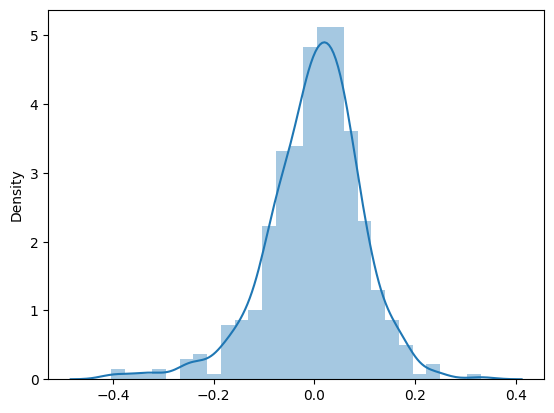

In [88]:
residuals = y_train - y_train_pred
sns.distplot(residuals)
plt.show()

In [89]:
cols = ['temp', 'windspeed', 'season_summer', 'season_winter', 'yr_2019', 'mnth_Sept', 'weathersit_Light Rain', 'weathersit_Mist and/or Cloudy']


In [90]:
df_test[scale]=scaler.transform(df_test[scale])
df_test.head()

,temp,atemp,hum,windspeed,casual,registered,cnt,season_spring,season_summer,season_winter,...,holiday_No Holiday,weekday_Mon,weekday_Sat,weekday_Sun,weekday_Thurs,weekday_Tue,weekday_Wed,workingday_Working Day,weathersit_Light Rain,weathersit_Mist and/or Cloudy
184,0.831783,0.769660,0.657364,0.084219,0.933557,0.427086,0.692706,0,0,0,...,0,0,0,0,0,1,0,1,0,1
535,0.901354,0.842587,0.610133,0.153728,0.265163,0.767976,0.712034,0,1,0,...,1,0,0,0,1,0,0,0,0,0
299,0.511964,0.496145,0.837699,0.334206,0.072539,0.346376,0.303382,0,0,1,...,1,0,0,0,0,0,0,0,0,1
221,0.881625,0.795343,0.437098,0.339570,0.268820,0.559630,0.547400,0,0,0,...,1,0,0,0,1,0,0,0,0,0
152,0.817246,0.741471,0.314298,0.537414,0.223712,0.608143,0.569029,0,1,0,...,1,0,0,0,0,0,0,0,0,0


In [91]:
y_test = df_test.pop('cnt')
X_test = df_test

In [92]:
X_test = X_test[cols]
X_test_sm = sm.add_constant(X_test)


In [93]:
y_test_pred = lr_24.predict(X_test_sm)

In [94]:
r_squared = r2_score(y_test, y_test_pred)
r_squared

0.7907818070220923